**Sustainable Software Development, block course, March 2021**  
*Scientific Software Center, Institute for Scientific Computing, Dr. Inga Ulusoy*

# Analysis of the data

Imagine you perform a "measurement" of some type and obtain "scientific data". You know what your data represents, but you have only a vague idea how different features in the data are connected, and what information you can extract from the data.

You would start first with going through the data, making sure your data set is complete and that the result is reasonable. Imagine this already happened.

In the next step, you would inspect your data more closely and try to identify structures. That is the step that we are focusing on in this unit.

In the `data` folder, you will find several data files (`*.t` and `*.dat`). These are data files generated through some "new approach" that hasn't been used in your lab before. No previous analysis software exists, and you are going to establish a protocol for this "new approach" and "publish your results".

The data can be grouped into two categories: 
1. data to be analyzed using statistical methods;
2. data to be analyzed using numerical methods.

In your hypothetical lab, you are an "expert" in one particular "method", and your co-worker is an "expert" in the other. Combined these two methods will lead to much more impactful results than if only one of you analyzed the data. Now, the task in this course is to be solved collaboratively with your team member working on one of the analysis approaches, and you working on the other. You will both implement functionality into the same piece of "software", but do so collaboratively through git.

As you do not know yet which analysis is most meaningful for your data, and how to implement it, you will start with a jupyter notebook. You and your team member will work on the same notebook that will be part of a github repository for your project. This is the task for today. Discuss with your team members who will work on the statistical and who on the numerical analysis.

## Step 1

Accept the assignment through GitHub classroom.

## Step 2

Clone the repository to your local machine.

## Step 3

Start working on task 1 for your analysis approach. 

## Step 4

Create your own branch of the repository and commit your changes to your branch; push to the remote repository.

## Step 5

Open a `pull request` so your team member can review your implementation. Likewise, your team member will ask you to review theirs.

## Step 6

Merge the changes in your branch into `main`. Resolve conflicts.

## Step 7

Repeat working on task; committing and pushing to your previously generated branch or a new branch; open a pull request; merge with main; until you have finished all the tasks in your analysis approach. Delete obsolete branches.

# Start of the analysis notebook

**Author : Your Name**  
*Date : The date you started working on this*  
*Affiliation : The entity under whose name you are working on this*  

Place the required modules in the top, followed by required constants and global functions.

In [10]:
# required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Union

In [6]:
# constants and global functions
filepathname = "../data"
filepath = Path(filepathname)
if not filepath.exists():
    raise FileNotFoundError(f"Directory {filepathname} does not exist.")
filenames = [f for f in filepath.glob("**.*") if f.is_file()]

In [7]:
filenames

[PosixPath('../data/efield.t'),
 PosixPath('../data/table.dat'),
 PosixPath('../data/npop.t'),
 PosixPath('../data/expec.t'),
 PosixPath('../data/nstate_i.t')]

In [24]:
# reading of the data files
def read_file(filename: Path, method: str) -> Union[pd.DataFrame, np.ndarray]:
    """Read the file and return content.
    
    Args:
        filename (Path): Path to the file.
        method (str): Method to read the file, either "pandas" or "numpy".
    Returns:
        pd.DataFrame | np.ndarray: Data read from the file."""
    if method == "pandas":
        return pd.read_csv(filename, sep=r"\s+")
    elif method == "numpy":
        return np.loadtxt(filename, delimiter="\t")
    else:
        raise ValueError("Method must be either 'pandas' or 'numpy'.")



# Statistical analysis

Find correlations in the data sets. Analyse the data statistically and plot your results.  

Here we would want to do everything with pandas and leave the data in a dataframe. The files that are relevant to you are `expect.t`, `npop.t` and `table.dat`.

### Task 1: Read in expec.t and plot relevant data

<Axes: title={'center': 'Energy over Time'}, xlabel='time'>

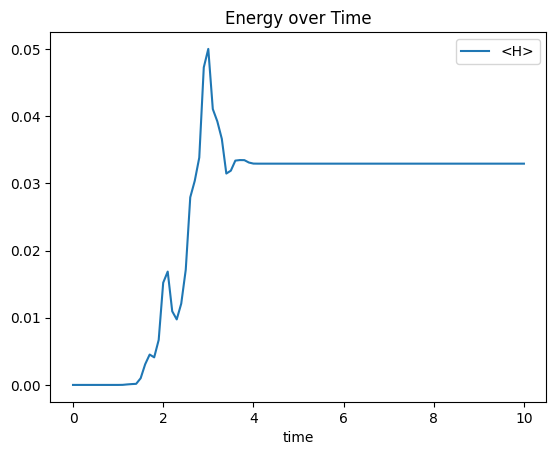

In [26]:
# read and plot expec.t
expect_df = read_file(filenames[3], "pandas")
# specify column names
expect_df.plot(x="time", y="<H>", kind="line", title="Energy over Time")

We can discard the entries norm, \<x>, and \<y> as these are mostly constant.

In [ ]:
# eliminate columns based on the variance: if the variance of the values
# in a column is below a given threshold, that column is discarded

### Task 2: Create plots of the relevant data and save as .pdf.

In [ ]:
# create plots

### Task 3: Read in file `npop.t` and analyze correlations in the data

In [ ]:
# read in npop.t

In [ ]:
# discard all columns with variance below a set threshold - we can consider them as constant

Plot the remaining columns. Seaborn prefers "long format" (one column for all measurement values, one column to indicate the type) as input, whereas the cvs is in "wide format" (one column per measurement type).

In [ ]:
# plot ideally with seaborn

## Quantify the pairwise correlation in the data

- negative correlation: y values decrease for increasing x - large values of one feature correspond to small values of the other feature
- weak or no correlation: no trend observable, association between two features is hardly observable
- positive correlation: y values increase for decreasing x - small values of one feature correspond to small values of the other feature

Remember that correlation does not indicate causation - the reason that two features are associated can lie in their dependence on same factors.

Correlate the value pairs using Pearson's $r$. Pearson's $r$ is a measure of the linear relationship between features:

$r = \frac{\sum_i(x_i − \bar{x})(y_i − \bar{y})}{\sqrt{\sum_i(x_i − \bar{x})^2 \sum_i(y_i − \bar{y})^2}}$

Here, $\bar{x}$ and $\bar{y}$ indicate mean values. $i$ runs over the whole data set. For a positive correlation, $r$ is positive, and negative for a negative correlation, with minimum and maximum values of -1 and 1, indicating a perfectly linear relationship. Weakly or not correlated features are characterized by $r$-values close to 0.

Other measures of correlation that can be used are Spearman's rank (value pairs follow monotonic function) or Kendall's $\tau$ (measures ordinal association), but they do not apply here. You can also define measures yourself.

In [ ]:
# print the correlation matrix

The diagonal values tell us that each value is perfectly correlated with itself. We are not interested in the diagonal values and also not in the correlation with time. We also need to get rid of redundant entries. Finally, we need to find the value pairs that exhibit the highest linear correlation. We still want to know if it is positive or negative correlation, so we cannot get rid of the sign.

In [ ]:
# get rid of time column, lower triangular and diagonal entries of the correlation matrix
# sort the remaing values according to their absolute value, but keep the sign

Note that the entries in the left column are not repeated if they do not change from the row above (so the fourth feature pair is MO3 and MO6).

### Task 4: Print the resulting data to a file

In [ ]:
# write to file

### Task 5: Calculate the Euclidean distance (L2 norm) for the vectors in `table.dat`


The Euclidean distance measures the distance between to objects that are not points:

$d(p,q) = \sqrt{\left(p-q\right)^2}$

In this case, consider each of the columns in table.dat as a vector in Euclidean space, where column $r(x)$ and column $v(x)$ denote a pair of vectors that should be compared, as well as $r(y)$ and $v(y)$, and r(z) and v(z).

(Background: These are dipole moment components in different gauges, the length and velocity gauge.)

In [1]:
# read in table.dat - I suggest reading it as a numpy array
# replace the NaNs by zero

Now calculate how different the vectors in column 2 are from column 3, column 4 from column 5, and column 6 from column 7.

In [ ]:
# calculate the Euclidean distance

In [2]:
# plot the result and save to a .pdf

In [ ]:
# print the result to a file

# Numerical analysis

Analyze the data using autocorrelation functions and discrete Fourier transforms. Plot your results.

In [ ]:
# define some global functions

### Task 1: Read in `efield.t` and Fourier-transform relevant columns

In [ ]:
# read and plot efield.t

Here we are interested in column 2 since the others are constant.

In [ ]:
# discard the columns with variance below threshold - these are considered constant

In [ ]:
# discrete Fourier transform of the remaining column: You only need the real frequencies

### Task 2: Generate a plot of your results to be saved as pdf.

In [ ]:
# plot your results

### Task 3: Calculate the autocorrelation function from nstate_i.t
The autocorrelation function measures how correlated subsequent vectors are with an initial vector; ie. 

$\Psi_{corr} = \langle \Psi(t=0) | \Psi(t) \rangle = \int_0^{tfin} \Psi(0)^* \Psi(t) dt$

Since we are in a numerical representation, the integral can be replaced with a sum; and the given vectors are already normalized.

In [ ]:
# read in as numpy array

In [3]:
# store the time column (column 0) in a vector and drop from array

In [4]:
# correct the data representation: this is in fact a complex matrix
# the real part of each matrix column is contained in numpy array column 0, 2, 4, 6, ...
# the imaginary part of each matrix column is contained in numpy array column 1, 3, 5, 7, ...
# convert the array that was read as dtype=float into a dtype=complex array

In [ ]:
# for the autocorrelation function, we want the overlap between the first vector at time 0 and all
# subsequent vectors at later times - the sum of the product of initial and subsequent vectors for each time step

### Task 4: Generate a plot of your results to be saved as pdf.

In [ ]:
# plot the autocorrelation function - real, imaginary and absolute part

### Task 5: Discrete Fourier transform of the autocorrelation function

In [ ]:
# discrete Fourier-transform the autocorrelation function - now we need all frequency components,
# also the negative ones

### Task 6: Generate a plot of your results to be saved as pdf.

In [5]:
# plot the power spectrum (abs**2)